# Linear Regression Model for Predicting House Prices

# Import necessary libraries

In [2]:
import numpy as np 
import pandas as pd
from math import sqrt
from scipy.stats import skew
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
plt.style.use(style='fivethirtyeight')
plt.rcParams['figure.figsize'] = (10, 6)

# Exploratory Data Analysis

In [4]:
# load the datasets into dataframe
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

In [5]:
# show the first few records of train set
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
# check the number of records and columns in both of datasets
print('No. of records in train dataset: ', len(train.index))
print('No. of columns in train dataset: ', len(train.columns))
print('No. of records in test dataset: ', len(test.index))
print('No. of columns in test dataset: ', len(test.columns))

No. of records in train dataset:  1460
No. of columns in train dataset:  81
No. of records in test dataset:  1459
No. of columns in test dataset:  80


In [7]:
# check the missing values
print ('Total missing values in train set', sum(train.isna().sum()))
print ('Total missing values in test set', sum(test.isna().sum()))

Total missing values in train set 6965
Total missing values in test set 7000


In [8]:
# check the missing values
print ('Total missing values in train set', sum(train.isna().sum()))
print ('Total missing values in test set', sum(test.isna().sum()))

Total missing values in train set 6965
Total missing values in test set 7000


In [9]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [10]:
numeric_cols = train.select_dtypes(include = [np.number])
corr = numeric_cols.corr()
print ('The Most Correlated Features with SalePrice:'), print (corr['SalePrice'].sort_values(ascending = False)[:10], '\n')
print ('The Most Uncorrelated Features with SalePrice:'), print (corr['SalePrice'].sort_values(ascending = False)[-5:])

The Most Correlated Features with SalePrice:
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64 

The Most Uncorrelated Features with SalePrice:
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


(None, None)

Text(0.5, 0, 'GrLivArea (Above grade "ground" living area square feet)')

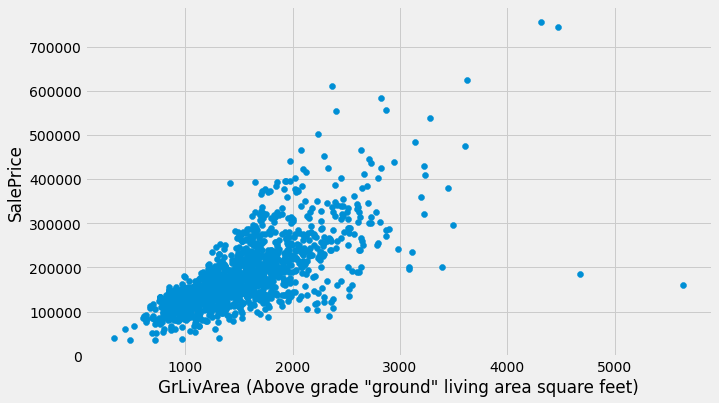

In [11]:
plt.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('GrLivArea (Above grade "ground" living area square feet)')

At first glance, there are increases in living area correspond to increases in price, with few outliers.

Text(0.5, 0, 'GarageArea')

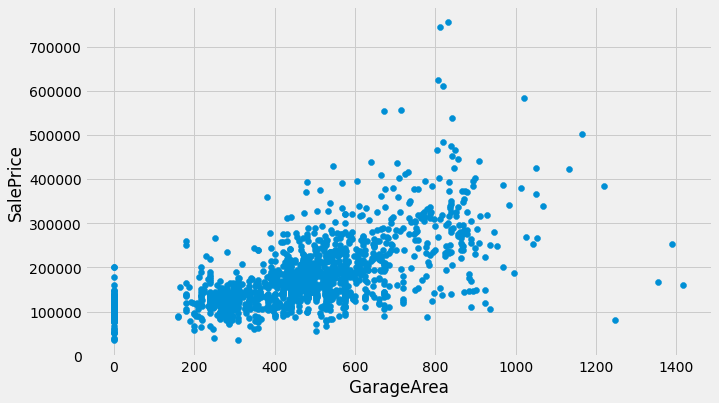

In [12]:
plt.scatter(x = train['GarageArea'], y = train['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('GarageArea')

So there are many homes with 0 for GarageArea and there are a few outliers as well!

# Data Preprocessing

In this section the data is prepared (transformed, encoded, etc) to make it suitable for a building and training machine learning model. I chose to manually remove certain extreme outliers in the dataset to produce a better fit.

In [13]:
# remove GrLivArea outliers
train = train[train['GrLivArea'] < 4500]

In [14]:
# remove GarageArea outliers
train = train[train['GarageArea'] < 1200]

In [15]:
# drop columns with percentage of missing values > 80%
train_percentage = train.isnull().sum() / train.shape[0]
print (train_percentage[train_percentage > 0.80])
train = train.drop(train_percentage[train_percentage > 0.80].index, axis = 1)

Alley          0.937414
PoolQC         0.995873
Fence          0.806740
MiscFeature    0.963549
dtype: float64


In [16]:
# do the same with test data
test_percentage = test.isnull().sum() / test.shape[0]
print (test_percentage[test_percentage > 0.80])
test = test.drop(test_percentage[test_percentage > 0.80].index, axis = 1)

Alley          0.926662
PoolQC         0.997944
Fence          0.801234
MiscFeature    0.965045
dtype: float64


In [17]:
# encode categorical variables
le = preprocessing.LabelEncoder()
for name in train.columns:
    if train[name].dtypes == 'O':
        train[name] = train[name].astype(str)
        le.fit(train[name])
        train[name] = le.transform(train[name])

In [18]:
# do the same for testset
for name in test.columns:
    if test[name].dtypes == 'O':
        test[name] = test[name].astype(str)
        le.fit(test[name])
        test[name] = le.transform(test[name])

There are many ways to handle NaN values, whether to fill with the mean or median, however strings cannot be averaged or median-ed. One way to fill missing values is to impute these missing values according to their probability of occuring in the dataset to avoid single-valued imputation that impacts the quality of inference and prediction.

In [19]:
# fill missing values based on probability of occurrence
for column in train.columns:
    null_vals = train.isnull().values
    a, b = np.unique(train.values[~null_vals], return_counts = 1)
    train.loc[train[column].isna(), column] = np.random.choice(a, train[column].isnull().sum(), p = b / b.sum())

In [20]:
# apply log transformation to reduce skewness over .75 by taking log(feature + 1)
skewed_train = train.apply(lambda x: skew(x.dropna()))
skewed_train = skewed_train[skewed_train > .75]
train[skewed_train.index] = np.log1p(train[skewed_train.index])

In [21]:
# deal with the skewness in the test data
skewed_test = test.apply(lambda x: skew(x.dropna()))
skewed_test = skewed_test[skewed_test > .75]
test[skewed_test.index] = np.log1p(test[skewed_test.index])

# Modelling

I will perform a simple linear regression on the dataset to predict house prices. In order to train out the regression model, we need to first split up the data into an X list that contains the features to train on, and a y list with the target variable, in this case, the Price column.

In [22]:
X = train.drop(['SalePrice', 'Id'], axis = 1)
y = train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [23]:
lr = linear_model.LinearRegression()

Then using the fit method to "fit" the model to the dataset. What this does is nothing but make the regressor "study" the data and "learn" from it.

In [24]:
model = lr.fit(X_train, y_train)

R-squared is the measure of how close the data are to the fitted regression line, in other words it measures the strength of the relationship between the model and the SalePrice on a convenient 0 – 100% scale.

In [25]:
# make predictions based on model
predictions = model.predict(X_test)

In [26]:
print ('MAE is:', mean_absolute_error(y_test, predictions))
print ('MSE is:', mean_squared_error(y_test, predictions))
print ('RMSE is:', sqrt(mean_squared_error(y_test, predictions)))

MAE is: 0.08673250448358115
MSE is: 0.01661813502661884
RMSE is: 0.12891134560859585


Text(0.5, 1.0, 'Linear Regression Model')

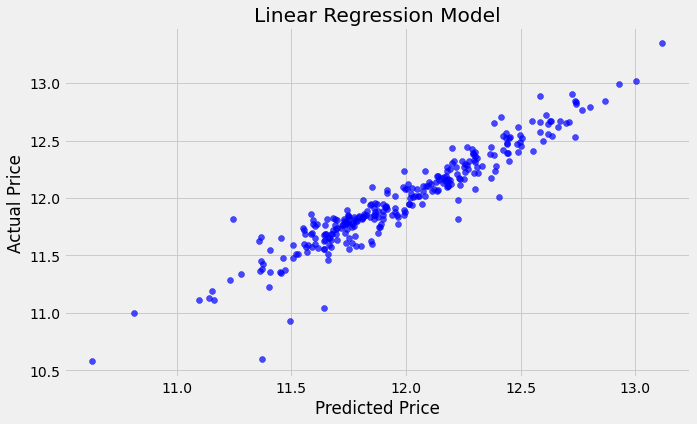

In [27]:
# alpha helps to show overlapping data
plt.scatter(predictions, y_test, alpha = 0.7, color = 'b')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')